This notebook will load the cleaned Phase‑1 output and perform in‑depth EDA, including:

- Review statistics

- Text-level insights

- Product-level patterns

- Customer-level behavior

- Outlier & anomaly detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")

%matplotlib inline
sns.set(style="whitegrid")

In [4]:
from pathlib import Path

# Use the current working directory as the base
project_root = Path.cwd().parent.parent  # adjust if needed to point to ML_DB_PROJECT

# Output directory
out_dir = project_root / "data/ml/reviews/reviews_preprocessed"
out_dir.mkdir(parents=True, exist_ok=True)

DF_PATH = out_dir / "reviews_preprocessed.parquet"
df = pd.read_parquet(DF_PATH)

Rating Distribution

C:\Users\ND.COM\AppData\Local\Temp\ipykernel_5576\4197176793.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rating', palette="viridis")


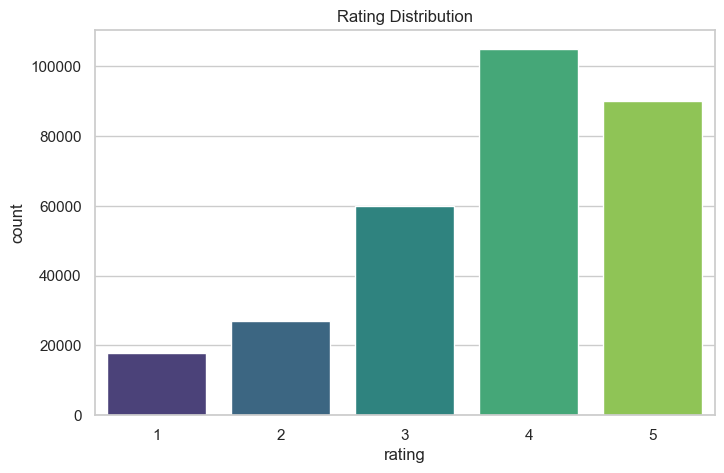

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='rating', palette="viridis")
plt.title("Rating Distribution")
plt.show()

Review Length Distribution

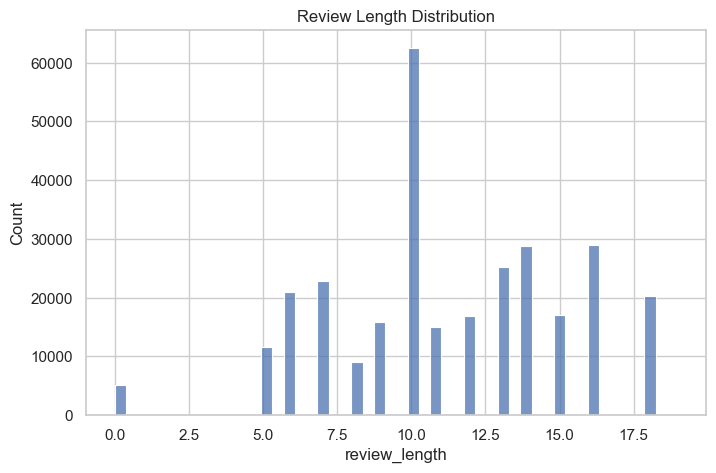

In [9]:
df['review_length'] = df['clean_text'].str.split().apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.show()

Temporal Trends

C:\Users\ND.COM\AppData\Local\Temp\ipykernel_5576\827337175.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['created_at'].dt.to_period('M')


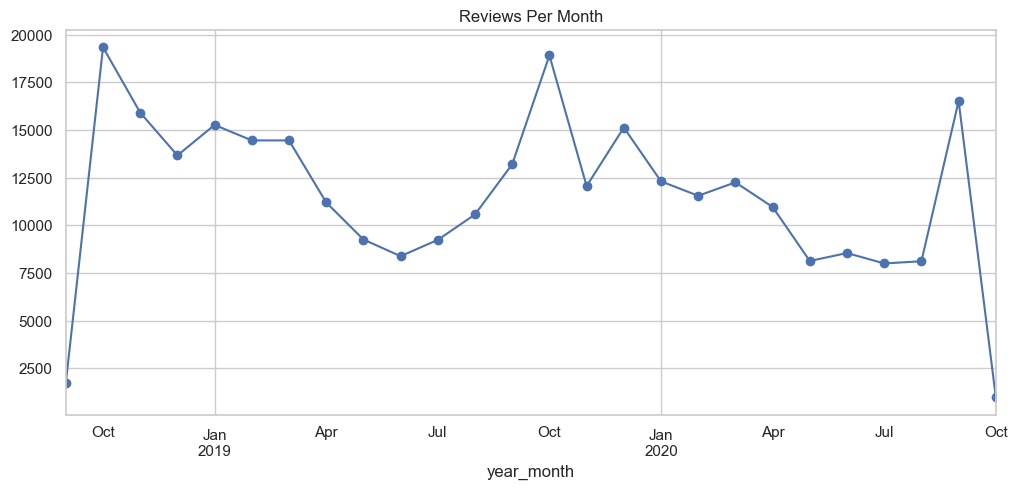

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['year_month'] = df['created_at'].dt.to_period('M')

monthly = df.groupby('year_month').size()

monthly.plot(figsize=(12,5), marker='o', title="Reviews Per Month")
plt.show()

Correlation: Review Length vs Rating

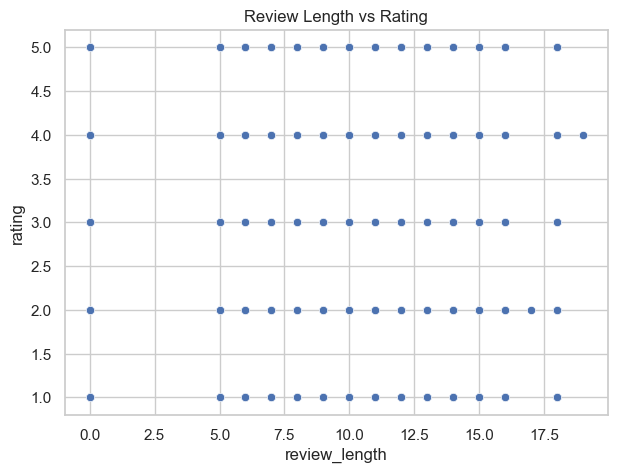

In [10]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='review_length', y='rating')
plt.title("Review Length vs Rating")
plt.show()

Verified vs Unverified Differences

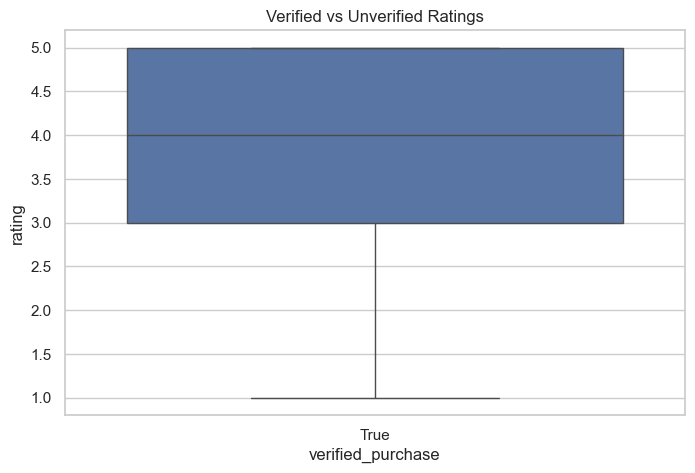

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='verified_purchase', y='rating')
plt.title("Verified vs Unverified Ratings")
plt.show()

## TEXT EDA

Word Clouds (Positive / Neutral / Negative)

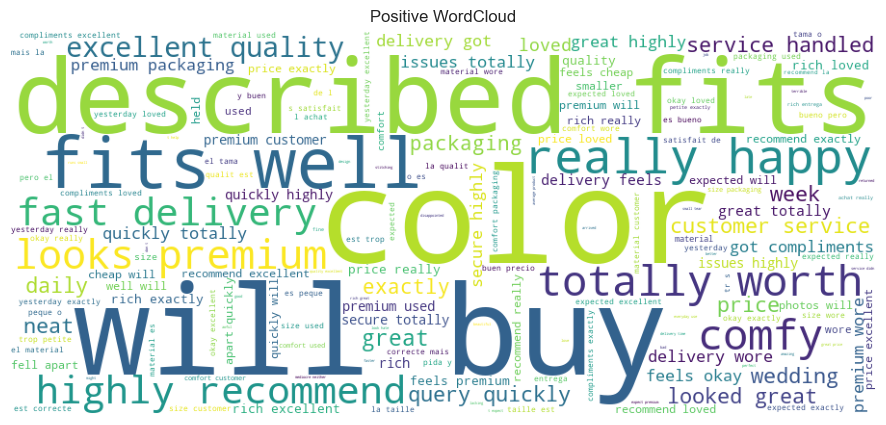

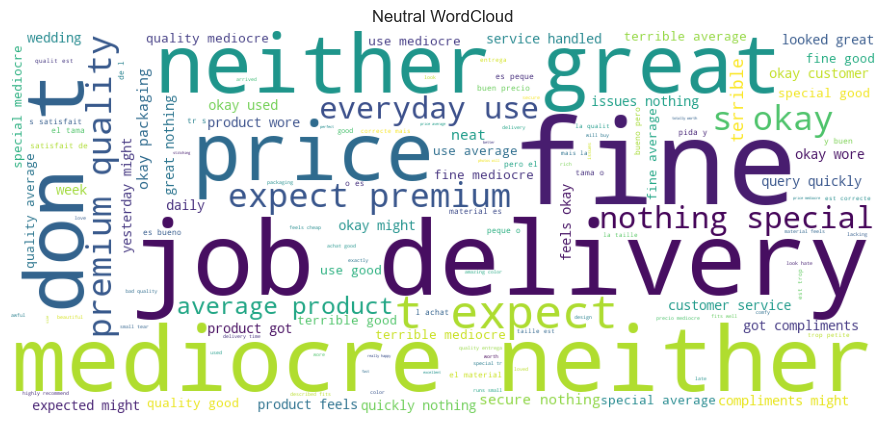

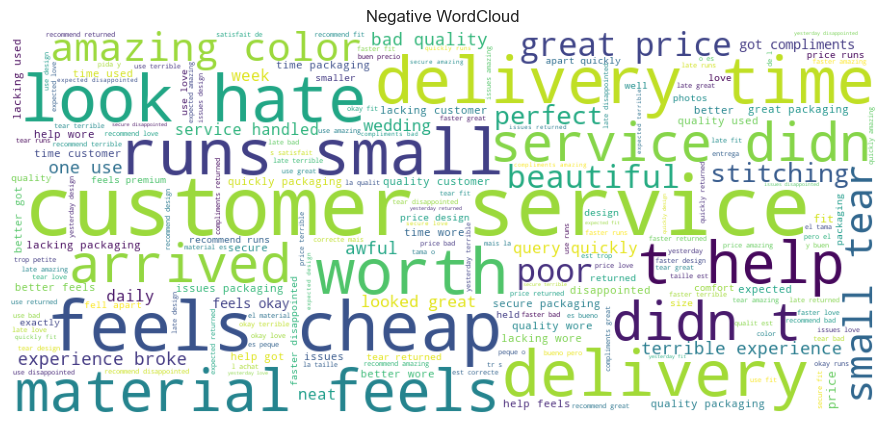

In [14]:
def make_wordcloud(text_data, title):
    wc = WordCloud(width=900, height=400, background_color="white").generate(" ".join(text_data))
    plt.figure(figsize=(12,5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()

make_wordcloud(df[df.synthetic_sentiment_label=='positive'].clean_text.sample(5000), "Positive WordCloud")
make_wordcloud(df[df.synthetic_sentiment_label=='neutral'].clean_text.sample(5000), "Neutral WordCloud")
make_wordcloud(df[df.synthetic_sentiment_label=='negative'].clean_text.sample(5000), "Negative WordCloud")

Most Frequent Adjectives

In [15]:
def get_adjectives(texts, limit=50):
    adj_list = []
    for doc in nlp.pipe(texts, batch_size=200):
       adj_list.extend([token.text for token in doc if token.pos_ == "ADJ"])
    return Counter(adj_list).most_common(limit)


adjectives = get_adjectives(df.clean_text.sample(10000))
pd.DataFrame(adjectives, columns=['adjective','count'])

,adjective,count
0,great,2524
1,premium,1558
2,worth,1368
3,comfy,1250
4,recommend,1250
5,happy,1237
6,rich,1210
7,fast,1184
8,excellent,1183
9,neat,843


Bigram / Trigram Analysis

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,3), max_features=10000, stop_words='english')
ngrams = cv.fit_transform(df.clean_text)

sum_words = ngrams.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
pd.DataFrame(words_freq[:30], columns=['ngram','count'])

,ngram,count
0,worth price,40776
1,comfy looks,36783
2,highly recommend,36779
3,looks premium,36774
4,comfy looks premium,36772
5,described fits,36728
6,fits color,36728
7,described fits color,36719
8,color rich,36718
9,fits color rich,36718


Category-wise TF‑IDF Keyword Extraction

In [ ]:
categories = df.category_id.unique()
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

keywords = {}
for cat in categories:
    texts = df[df.category_id==cat].clean_text
    if len(texts) < 200: # skip low volume categories
        continue
    tfidf = vectorizer.fit_transform(texts)
    scores = zip(vectorizer.get_feature_names_out(), tfidf.sum(axis=0).tolist()[0])
    top = sorted(scores, key=lambda x: x[1], reverse=True)[:20]
    keywords[cat] = top

keywords

## PRODUCT LEVEL INSIGHTS

Top Products with Most Reviews

In [18]:
top_products = df.groupby('article_id').size().sort_values(ascending=False).head(20)
top_products

article_id
399223001    3342
399256001    3125
636323001    2066
399256005    1897
685814001    1699
399223029    1503
715624001    1322
714790020    1258
399223033    1258
685814003    1254
799365002    1185
714790008    1117
399087014    1095
714790003    1062
399087010    1050
658030011    1038
399201005    1007
687704001    1007
636323002    1006
399201022     992
dtype: int64

Most Controversial Products

In [19]:
controversial = df.groupby('article_id').rating.std().sort_values(ascending=False).head(20)
controversial

article_id
735833002    2.828427
636454001    2.828427
749823001    2.828427
613952001    2.828427
868444002    2.828427
542551018    2.828427
686270003    2.828427
509893020    2.828427
686126008    2.828427
730863037    2.828427
746296004    2.828427
716930001    2.828427
649538001    2.828427
505216002    2.828427
685510001    2.828427
757101006    2.828427
882033002    2.828427
563189005    2.309401
708300006    2.309401
569973027    2.309401
Name: rating, dtype: float64

Average Rating per Category

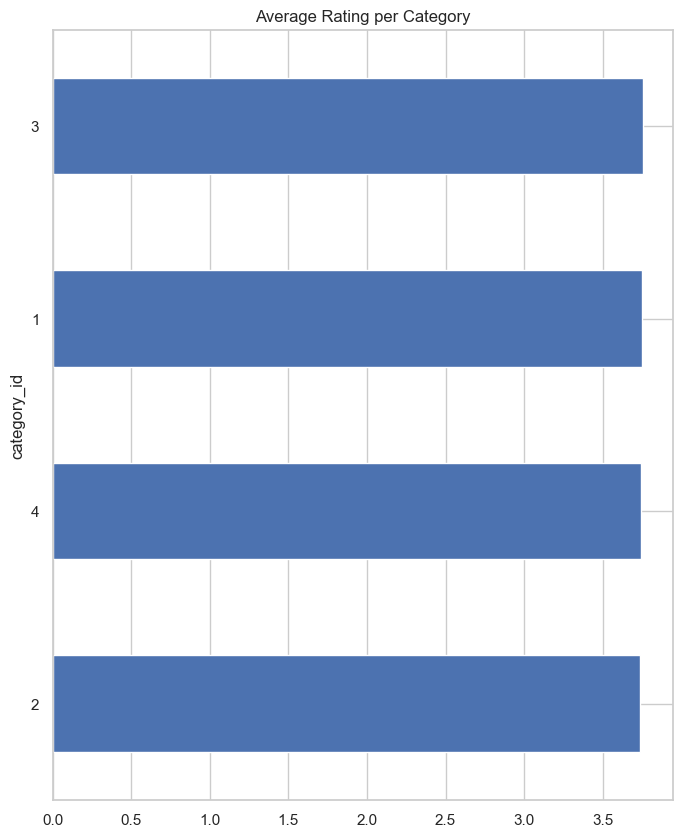

In [20]:
cat_rating = df.groupby('category_id').rating.mean().sort_values()
cat_rating.plot(kind='barh', figsize=(8,10), title="Average Rating per Category")
plt.show()

## CUSTOMER LEVEL INSIGHTS

Customer Review Behavior

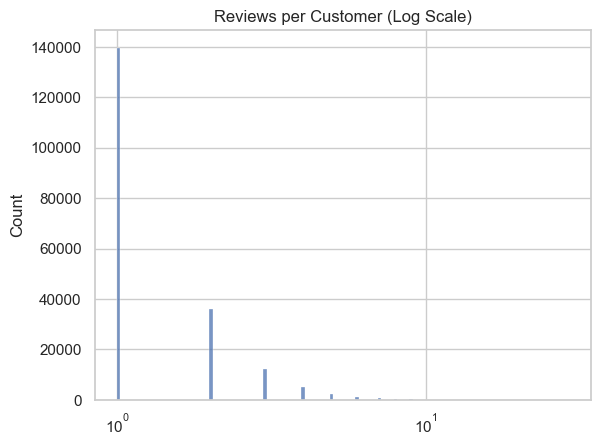

In [21]:
cust_counts = df.groupby('customer_id').size()
sns.histplot(cust_counts, log_scale=True)
plt.title("Reviews per Customer (Log Scale)")
plt.show()

Harsh vs Generous Reviewers

In [22]:
reviewer_profiles = df.groupby('customer_id').rating.mean()
reviewer_profiles.describe()

count    198018.000000
mean          3.743408
std           1.047806
min           1.000000
25%           3.000000
50%           4.000000
75%           4.500000
max           5.000000
Name: rating, dtype: float64

## OUTLIER DETECTION

Repeated Word Spam

In [ ]:
def repetition_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    freq = Counter(words)
    most_common = freq.most_common(1)[0][1]
    return most_common / len(words)


df['repeat_ratio'] = df.clean_text.apply(repetition_ratio)
spammy = df[df.repeat_ratio > 0.4]
spammy.head()

## already removed

,review_id,customer_id,article_id,category_id,rating,review_text,created_at,verified_purchase,helpful_votes,synthetic_sentiment_label,...,tokens,lemmas,sentences,language_detected,translated_text,is_spam,final_text_for_ml,text_for_training,year_month,repeat_ratio


Sentiment vs Rating Mismatch

In [ ]:
def sentiment_numeric(label):
    return {"negative":1, "neutral":3, "positive":5}.get(label,3)


mismatch = df[abs(df.rating - df.synthetic_sentiment_label.apply(sentiment_numeric)) >= 3]
mismatch.head()

# already fixed

,review_id,customer_id,article_id,category_id,rating,review_text,created_at,verified_purchase,helpful_votes,synthetic_sentiment_label,...,tokens,lemmas,sentences,language_detected,translated_text,is_spam,final_text_for_ml,text_for_training,year_month,repeat_ratio
